In [2]:
import os, random,cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 
import torch

### 导入数据

In [3]:
TRAIN_DIR = 'train/'
TEST_DIR = 'test1/'

ROWS = 64
COLS = 64
CHANNELS = 3

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]


# slice datasets for memory efficiency on Kaggle Kernels, delete if using full dataset
train_images = train_dogs[:1000] + train_cats[:1000]
random.shuffle(train_images)
test_images =  test_images[:25]

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%250 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

train = prep_data(train_images)
test = prep_data(test_images)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Processed 0 of 2000
Processed 250 of 2000
Processed 500 of 2000
Processed 750 of 2000
Processed 1000 of 2000
Processed 1250 of 2000
Processed 1500 of 2000
Processed 1750 of 2000
Processed 0 of 25
Train shape: (2000, 3, 64, 64)
Test shape: (25, 3, 64, 64)


### 查看类别是否均衡

Text(0.5,1,'Cats and Dogs')

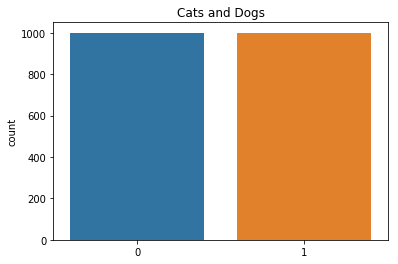

In [4]:
labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)

ax = sns.countplot(labels)
ax.set_title('Cats and Dogs')


In [5]:
type(train)

numpy.ndarray

### 查看样本

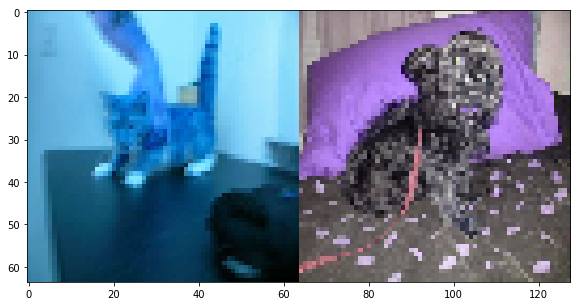

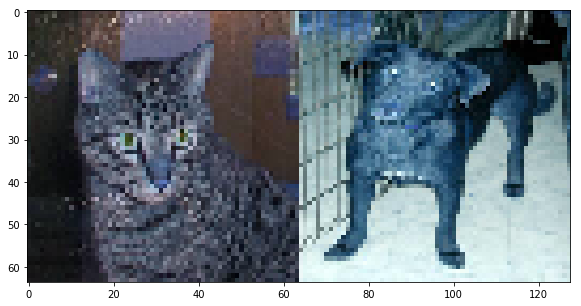

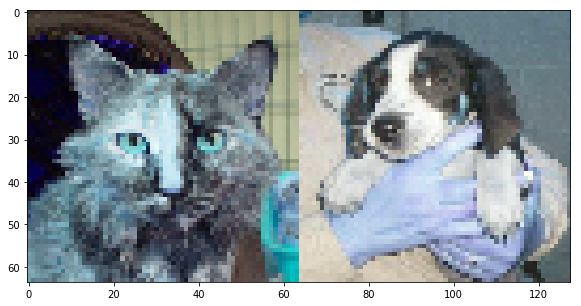

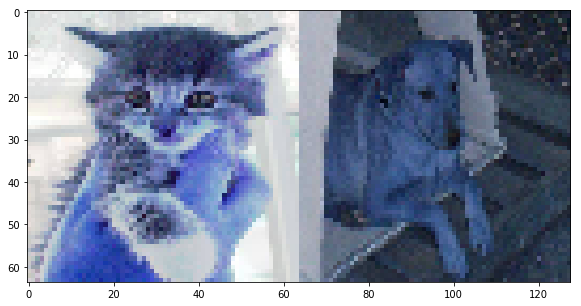

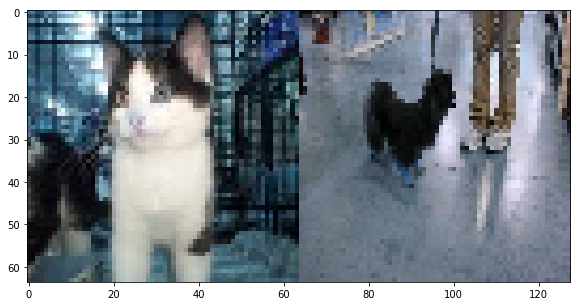

In [6]:
def show_cats_and_dogs(idx):
    cat = read_image(train_cats[idx])
    dog = read_image(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
    
for idx in range(0,5):
    show_cats_and_dogs(idx)

### 使用VGG-16训练

In [7]:
from torchvision import models

In [8]:
vgg16 = models.vgg16(pretrained=True)


In [9]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt


In [10]:
EPOCH = 1
BATCH_SIZE = 100
LR = 0.001

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Sequential(
                     #(16.28,28)
                     nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5,stride=1,padding=2),
                     nn.ReLU(),
                     nn.MaxPool2d(kernel_size=2)#(16,32,32)
                     )
        self.conv2 = nn.Sequential(
                     nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5,stride=1,padding=1),
                     nn.ReLU(),
                     nn.MaxPool2d(2)#(32,16,16)
                     )
        self.out = nn.Linear(32*16*16,2)
        
    def forward(self,x):
        x= np.float64(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0),-1)
        output = self.out(x)
        return output
    
    
        

In [12]:
cnn = CNN()
print(cnn)
t7train = torch.from_numpy(np.float64(train))
t7labels = torch.from_numpy(np.ndarray(labels))
train_data = Data.TensorDataset(data_tensor=t7train,target_tensor=t7labels)
loader = Data.DataLoader(
    dataset=train_data,      # torch TensorDataset format
    batch_size=BATCH_SIZE,      # mini batch size
    shuffle=True,               # 要不要打乱数据 (打乱比较好)
)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (out): Linear(in_features=8192, out_features=2, bias=True)
)


ValueError: sequence too large; cannot be greater than 32

In [59]:
type(t7labels)

torch.IntTensor

In [60]:
optimizer =torch.optim.Adam(cnn.parameters(),lr = LR)
loss_function = nn.CrossEntropyLoss()

for epoch in range(EPOCH):
    for step,(x,y) in enumerate(loader):
        b_x = Variable(x)
        b_y = Variable(y)
        
        output = cnn(b_x)
        loss = loss_function(output,b_y)
        optimizer.zero_grad()
        optimizer.step()
        
        if step %100 ==0:
            print('Epoch:', epoch, '|Step:', step,  
                  '|train loss:%.4f'%loss.data[0])  
            
  

AttributeError: 'numpy.ndarray' object has no attribute 'dim'